In [1]:
# 導入所需的函式庫
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm 
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
print('Tensorflow   :', tf.__version__)

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


Tensorflow   : 2.7.0


In [2]:
# 設置一些參數
IMG_WIDTH = 1280
IMG_HEIGHT = 720
IMG_CHANNELS = 3
TRAIN_PATH = './input/train/'
TEST_PATH = './input/test/'
WEIGHT_FILE = 'model-river-land-forest.h5'

In [3]:
# 獲取並調整訓練圖像和遮罩的大小
def get_data(path, train=True):
    ids = next(os.walk(path + "/images/"))[2]
    X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        # 載入圖片
        img = load_img(path + '/images/' + id_, color_mode="rgb")
        x_img = img_to_array(img)
        x_img = resize(x_img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)

        fname, extension = os.path.splitext(id_)
        if extension != '.png':
            mask_id_ = fname + '.png'
        else:
            mask_id_ = id_
        # 載入遮罩
        if train:
            mask = img_to_array(load_img(path + '/masks/' + mask_id_, color_mode="rgb"))
            mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
        # Save images
        Red = x_img[:, :, 0]/255
        Green = x_img[:, :, 1]/255
        Blue = x_img[:, :, 2]/255

        new_img = np.stack((Red, Green, Blue), axis=2)
        X[n] = new_img    

        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(TRAIN_PATH, train=True)
print(X.shape, X.dtype, y.shape, y.dtype)

Getting and resizing images ... 


100%|██████████| 52/52 [00:21<00:00,  2.39it/s]

Done!
(52, 720, 1280, 3) float32 (52, 720, 1280, 3) float32


In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2021)

In [5]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(44, 720, 1280, 3) (8, 720, 1280, 3) (44, 720, 1280, 3) (8, 720, 1280, 3)


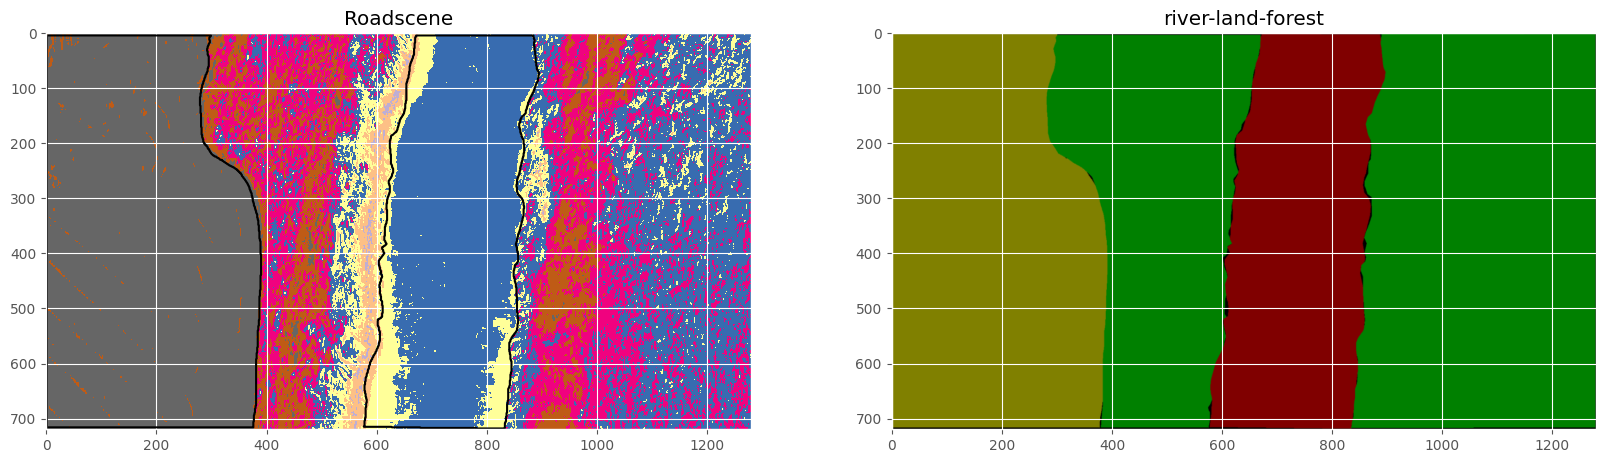

In [6]:
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='Accent', interpolation='bilinear')

if has_mask:
    y_train_2d = y_train[ix][:, :, 0]
    ax[0].contour(y_train_2d, colors='k', levels=[0.5])
ax[0].set_title('Roadscene')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('river-land-forest');

#定義卷積層

In [7]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
# 第一層
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
                padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    # 第二層
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
                padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    return x

#定義U-Net模型

In [8]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    

    outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [9]:
input_img = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='img')

In [10]:
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

In [11]:
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 720, 1280,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 720, 1280, 1  448         ['img[0][0]']                    
                                6)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 720, 1280, 1  64         ['conv2d[0][0]']                 
 alization)                     6)                                                            

In [12]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [26]:
results = model.fit(X_train, y_train, batch_size=5, epochs=130, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Epoch 1/130
9/9 [==============================] - ETA: 0s - loss: 0.3858 - accuracy: 0.9618
Epoch 00001: val_loss improved from 0.41133 to 0.40678, saving model to model-tgs-salt.h5
9/9 [==============================] - 17s 2s/step - loss: 0.3858 - accuracy: 0.9618 - val_loss: 0.4068 - val_accuracy: 0.8669 - lr: 1.0000e-04
Epoch 2/130
9/9 [==============================] - ETA: 0s - loss: 0.3851 - accuracy: 0.9576
Epoch 00002: val_loss improved from 0.40678 to 0.40332, saving model to model-tgs-salt.h5
9/9 [==============================] - 13s 1s/step - loss: 0.3851 - accuracy: 0.9576 - val_loss: 0.4033 - val_accuracy: 0.8806 - lr: 1.0000e-04
Epoch 3/130
9/9 [==============================] - ETA: 0s - loss: 0.3848 - accuracy: 0.9551
Epoch 00003: val_loss improved from 0.40332 to 0.39963, saving model to model-tgs-salt.h5
9/9 [==============================] - 12s 1s/step - loss: 0.3848 - accuracy: 0.9551 - val_loss: 0.3996 - val_accuracy: 0.8964 - lr: 1.0000e-04
Epoch 4/130
9/9 [==

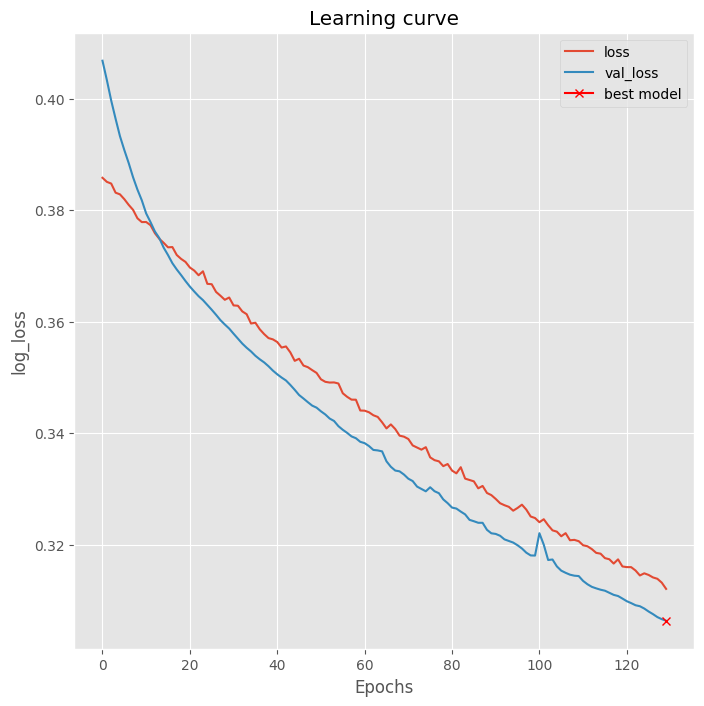

In [27]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [28]:
model.load_weights('model-tgs-salt.h5')

In [29]:
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 0s 423ms/step - loss: 0.3064 - accuracy: 0.9323


[0.3064137399196625, 0.9322713017463684]

In [30]:
preds_train = model.predict(X_train, batch_size=5, verbose=1)
preds_val = model.predict(X_valid, batch_size=5, verbose=1)

2/2 [==============================] - 0s 161ms/step


#繪製樣本圖像

In [31]:
def plot_sample(X, y, preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    ax[0].set_title('Input Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Actual Segmentation')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    ax[2].set_title('Predicted Segmentation')

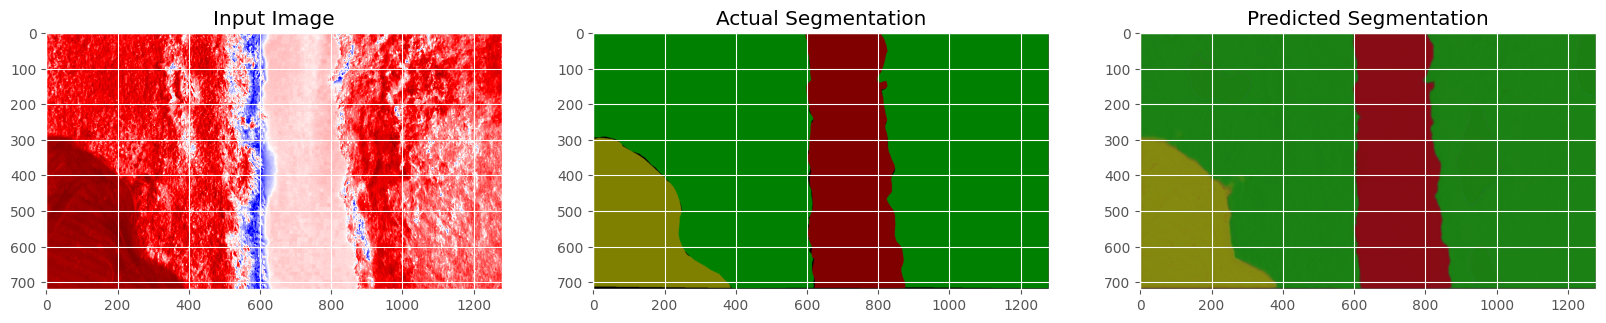

In [32]:
plot_sample(X_train, y_train, preds_train, ix=14)

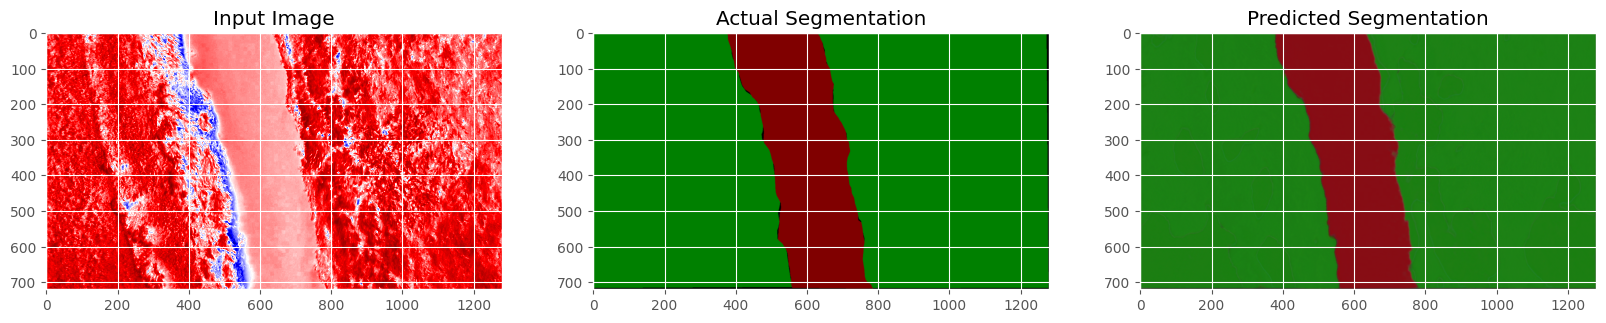

In [33]:
plot_sample(X_valid, y_valid, preds_val, ix=5)

In [34]:
X_test, y_test = get_data(TEST_PATH, train=True)

Getting and resizing images ... 


100%|██████████| 6/6 [00:02<00:00,  2.08it/s]

Done!


In [35]:
preds_test = model.predict(X_test, batch_size =1, verbose=1)

6/6 [==============================] - 0s 40ms/step


In [36]:
model.evaluate(X_test, y_test, batch_size=8, verbose=1)

1/1 [==============================] - 0s 292ms/step - loss: 0.3247 - accuracy: 0.9442


[0.32470694184303284, 0.9441704750061035]

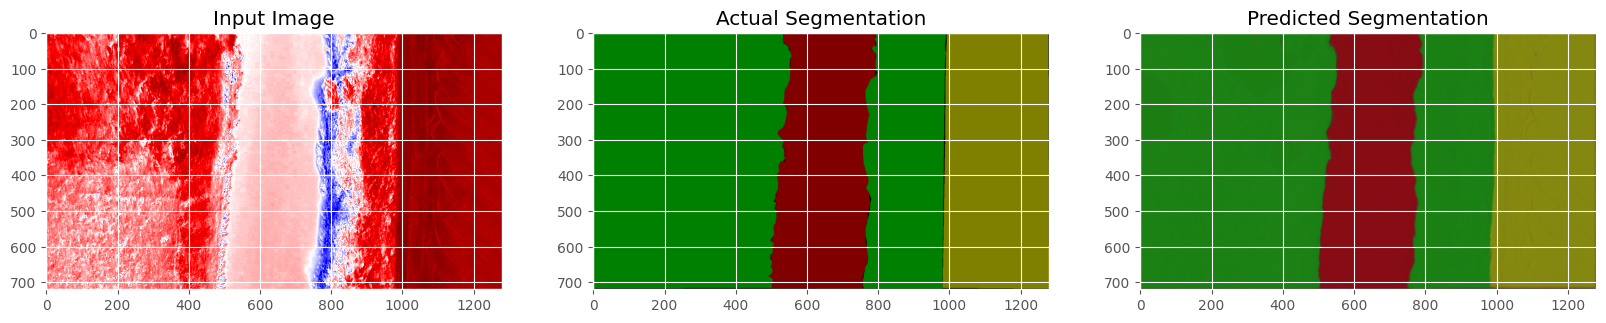

In [37]:
plot_sample(X_test, y_test, preds_test, ix=5)

#保存模型

In [25]:
tf.keras.models.save_model(model, 'model.h5')
tf.saved_model.save(model, 'saved_model')

INFO:tensorflow:Assets written to: saved_model\assets
